In [39]:
class InvalidState(ValueError):
    def __init__(self, message, *args):
        self.message = message # without this you may get DeprecationWarning
        super(InvalidState, self).__init__(message, *args)

In [40]:
import numpy as np
from skimage.transform import resize


def resize_activations(enhanced_model_output, input_shape):
    resized_activations = []
    for i in range(enhanced_model_output.shape[-1]):
        # resizing every activation map to original input image spatial dimensions
        resized_activations.append(resize(enhanced_model_output[..., i], input_shape, preserve_range=True))
    return np.array(resized_activations)


def normalize_activations(activation_maps):
    flattened = activation_maps.reshape((activation_maps.shape[0], -1))
    # min/max for each map
    max_a = np.max(flattened, axis=1)
    min_a = np.min(flattened, axis=1)

    # make norm = 1 where diff is zero (instead of adding/removing small epsilon)
    diffs = np.where(max_a > min_a, max_a - min_a, 1)
    return (activation_maps - min_a.reshape((-1, 1, 1))) / diffs.reshape((-1, 1, 1))

In [41]:
from keras import Model
import numpy as np


class ScoreCAM:
    def __init__(self, model_input, last_conv_output, softmax_output, input_shape, cam_batch_size=None):
        """
        Prepares class activation mappings
        :param model_input: input layer of CNN, normally takes batch of images as an input. Currently batch must be limited to a single image
        :param last_conv_output: last convolutional layer. The last conv layer contains the most complete information about image.
        :param softmax_output: flat softmax (or similar) layer describing the class certainty
        :param input_shape: Expecting a batch of a single input sample 1 x M X N X ...; it is assumed that 2D image of M x N dimensions is served as an input, which can be multiplied with a 2D-mask.
        :param cam_batch_size: Optional, defaults to None, which will result in inference of batches of size 32.
        """
        self.model_input = model_input
        self.last_conv_output = last_conv_output
        self.softmax_output = softmax_output
        self.last_conv_model = Model(inputs=model_input, outputs=last_conv_output)
        self.softmax_model = Model(inputs=model_input, outputs=softmax_output)
        self.input_shape = input_shape
        self.cam_batch_size = cam_batch_size

        self.normalized_maps = None
        self.classes_activation_scale = None

    def prepare_cam(self, input):
        output_conv = self.last_conv_model.predict(input)
        # Only first image from convolutions will be used
        resized = resize_activations(output_conv[0], self.input_shape)
        # filter_size x input_shape[0] x input_shape[1] - resized to original input dimensions
        normalized_maps = normalize_activations(resized)

        # repeat input
        repeat_input = np.tile(input, (normalized_maps.shape[0], 1, 1, 1))
        expanded_activation_maps = np.expand_dims(normalized_maps, axis=3)
        masked_images = np.multiply(repeat_input, expanded_activation_maps)
        # input: filter_size x input_shape[0] x input_shape[1] -> Output filter_size x Classes_Count
        self.classes_activation_scale = self.softmax_model.predict(masked_images,
                                                                   batch_size=self.cam_batch_size)
        self.normalized_maps = normalized_maps

    def get_class_heatmap(self, class_id):
        if self.normalized_maps is None or self.classes_activation_scale is None:
            raise InvalidState('Call prepare_cam before accessing get_class_heatmap, '
                               'activations must be prepared via prepare_cam')
        final_weights = self.classes_activation_scale[:, class_id]
        final_maps = np.multiply(self.normalized_maps, final_weights.reshape((-1, 1, 1)))
        # ReLU
        final_maps_max = np.max(final_maps, axis=0)
        final_class_activation_map = np.where(final_maps_max > 0, final_maps_max, 0)
        return final_class_activation_map

In [42]:
import keras
from keras.applications import VGG16
import numpy as np
model = VGG16(weights='imagenet')
input_shape = (224, 224)
conv_layers = model.layers[-6].output
softmax_output = model.layers[-1].output

In [43]:
from keras_applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array

source_img = load_img('H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_10388.JPEG', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

In [44]:
# model_input - is an input layer
# conv_layers - last convolutional layer output , in our case the layer_name = 'block5_conv3'
# softmax_output - final classification layer output

scoreCAM = ScoreCAM(model_input=model.input, last_conv_output=conv_layers, softmax_output=softmax_output, input_shape=input_shape)
scoreCAM.prepare_cam(img)

In [45]:
import matplotlib.pyplot as plt

#The output is a heatmap which describes an importance of a class class_id with respect to pixel location;
def draw_original_and_heatmap(class_id):
    heatmap = scoreCAM.get_class_heatmap(class_id)
    
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(heatmap, cmap='plasma')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(heatmap, cmap='plasma', alpha=0.5)

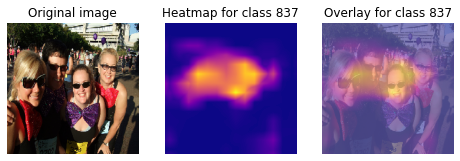

In [12]:
# 'n04356056', 'sunglasses'
sunglasses_id = 837
draw_original_and_heatmap(sunglasses_id)

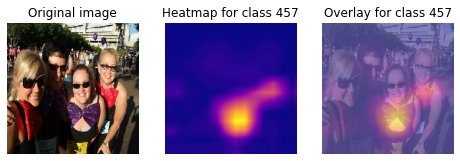

In [13]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_22630.JPEG
#[('n02110958', 'pug', 0.86542296), ('n02883205', 'bow_tie', 0.057968)]

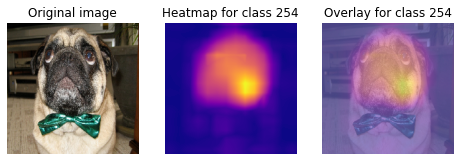

In [16]:

#'n02110958', 'pug'
pug_id = 254
draw_original_and_heatmap(pug_id)

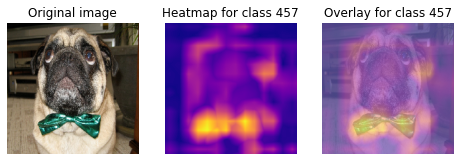

In [17]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_10388.JPEG
#[('n04356056', 'sunglasses', 0.1469911), ('n03995372', 'power_drill', 0.06765086), ('n03759954', 'microphone', 0.06381411), ('n03483316', 'hand_blower', 0.05753436), ('n03666591', 'lighter', 0.054560095)]

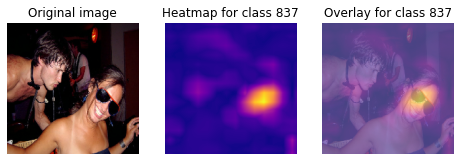

In [20]:
# 'n04356056', 'sunglasses'
sunglasses_id = 837
draw_original_and_heatmap(sunglasses_id)

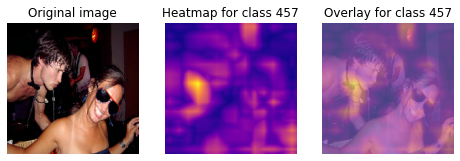

In [46]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_14158.JPEG
#[('n03709823', 'mailbag', 0.24760392), ('n04026417', 'purse', 0.1590362), ('n04325704', 'stole', 0.14805184), ('n02963159', 'cardigan', 0.0409956), ('n02883205', 'bow_tie', 0.03724567)]

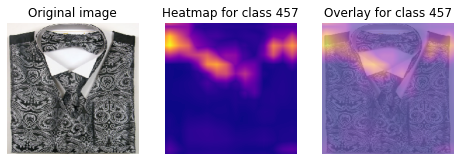

In [24]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_24815.JPEG
#[('n03630383', 'lab_coat', 0.11198765), ('n02883205', 'bow_tie', 0.099111244), ('n04350905', 'suit', 0.09864194), ('n04200800', 'shoe_shop', 0.061043672), ('n04591157', 'Windsor_tie', 0.053949356)]

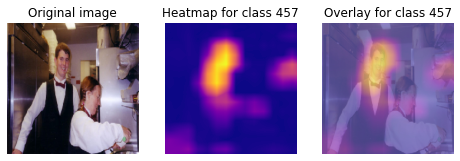

In [144]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
#draw_original_and_heatmap(bowtie_id)
draw_original_and_heatmap_bw(bowtie_id)

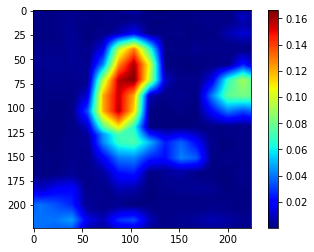

In [21]:
import matplotlib.pyplot as plt
heatmap = scoreCAM.get_class_heatmap(457)
h=normalize_activations(heatmap)
plt.imshow(h,cmap='jet')
plt.colorbar()
#problem : the heatmap is not properly scaled !!!!

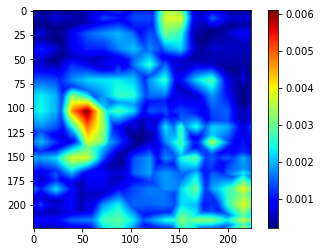

In [18]:
import matplotlib.pyplot as plt

h = scoreCAM.get_class_heatmap(457)
#normalize_activations(heatmap)
plt.imshow(heatmap,cmap='jet')
plt.colorbar()
#problem : the heatmap is not properly scaled !!!!

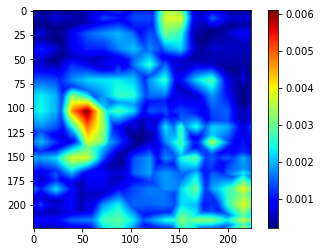

In [10]:
import matplotlib.pyplot as plt

h = scoreCAM.get_class_heatmap(457)
#normalize_activations(heatmap)
plt.imshow(h,cmap='jet')
plt.colorbar()
#problem : the heatmap is not properly scaled !!!!

In [16]:
heatmap.max()

0.16606452

In [32]:
heatmap.min()

0.00026071444

In [33]:
heatmap.max() - heatmap.min()

0.1658038

In [34]:
heatmap = scoreCAM.get_class_heatmap(457)

In [23]:
#im = cv2.imread(heatmap)
im1 = heatmap[149:170, 184:220]


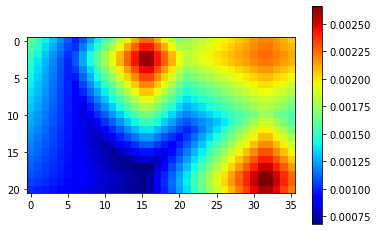

In [24]:
plt.imshow(im1,cmap='jet')
plt.colorbar()

In [25]:
perc = np.percentile(im1, 90)
perc 

0.002191995386965573

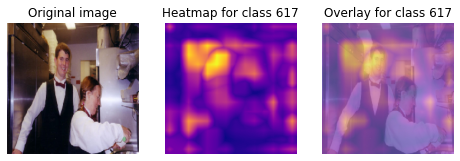

In [28]:
#'n03630383', 'lab_coat'
labcoat_id = 617
draw_original_and_heatmap(labcoat_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_5552.JPEG
#[('n02883205', 'bow_tie', 0.99077284), ('n04591157', 'Windsor_tie', 0.004336166), ('n04350905', 'suit', 0.0017518894), ('n10148035', 'groom', 0.0011925367), ('n02865351', 'bolo_tie', 0.00031562636)]

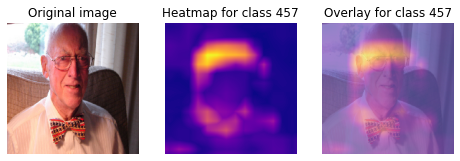

In [31]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

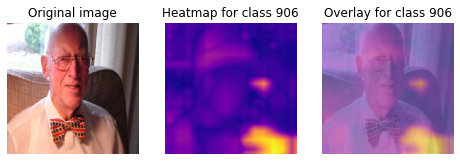

In [32]:
# 'n04591157', 'Windsor_tie'
Windsortie_id = 906
draw_original_and_heatmap(Windsortie_id)

In [ ]:
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_46341.JPEG
#[('n04350905', 'suit', 0.5250527), ('n02883205', 'bow_tie', 0.39113462), ('n04479046', 'trench_coat', 0.010250731), ('n04591157', 'Windsor_tie', 0.009458753), ('n03680355', 'Loafer', 0.007629351)]

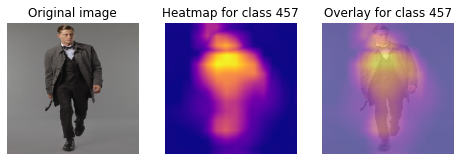

In [35]:
# 'n02883205', 'bow_tie'
bowtie_id = 457
draw_original_and_heatmap(bowtie_id)

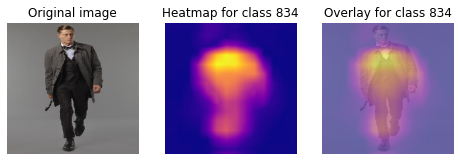

In [36]:
# 'n04350905', 'suit'
suit_id = 834
draw_original_and_heatmap(suit_id)

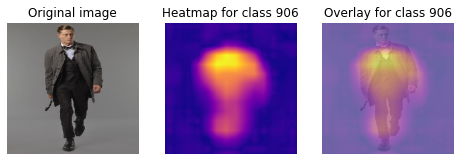

In [37]:
# 'n04591157', 'Windsor_tie'
Windsortie_id = 906
draw_original_and_heatmap(Windsortie_id)

In [45]:
import matplotlib.pyplot as plt

#The output is a heatmap which describes an importance of a class class_id with respect to pixel location;
def draw_original_and_heatmap_bw(class_id):
    heatmap = scoreCAM.get_class_heatmap(class_id)
    h=normalize_activations(heatmap)
    f = plt.figure(figsize=(8,8))
    left = f.add_subplot(131)
    left.set_title("Original image")
    left.axis('off')
    left.imshow(source_img)
    
    right = f.add_subplot(132)    
    right.set_title("Heatmap for class {}".format(class_id))
    right.axis('off')
    right.imshow(h, cmap='gist_gray')
    
    merged = f.add_subplot(133)    
    merged.set_title("Overlay for class {}".format(class_id))
    merged.axis('off')
    merged.imshow(source_img, alpha=0.5)
    merged.imshow(h, cmap='jet', alpha=0.5)

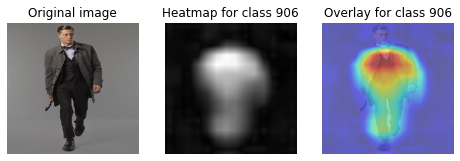

In [46]:
# 'n04591157', 'Windsor_tie'
Windsortie_id = 906
draw_original_and_heatmap_bw(Windsortie_id)

# custom loss function:

### draw BBox

In [ ]:
from PIL import Image
import os, sys
import pandas as pd
import cv2
import statistics
import numpy as np
df = pd.read_csv('R:/Bureau/n03297495.csv')
df2= df.drop('bbox',axis=1)
img_basenames = []
for file in os.listdir("R:/Bureau/n03297495_ScoreCAM/annot"):
    if file.endswith(".JPEG"):
        img_basenames.append(file)
for basename in img_basenames:
    f_name, f_ext = os.path.splitext(basename)
    #name = f_name[20:]
    name = f_name.replace('result_espresso_maker_','')
    name = name.replace('_resized','')
    n = df2['filename']
    im = Image.open(f'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n03297495/'+name+'.JPEG')
    #x,y=im.size
    #df2= df.drop('bbox',axis=1)
    if not (df2.loc[df2['filename'] == name]).empty:
        sorted_df = df2.sort_values(by='filename', ascending=True)
        B = sorted_df.loc[sorted_df['filename'] == name].values.tolist()
        xmin = B[0][2]
        ymin = B[0][3]
        xmax=B[0][4]
        ymax =B[0][5]
        n = B[0][1]
        path= f'R:/Bureau/n03297495_ScoreCAM/result_espresso_maker_'+name+'.JPEG'
        img = Image.open(path)
        #f = 'R:/Bureau/n04023962/'
        imag = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/result_espresso_maker_'+n+'_resized.JPEG')
        cv2.rectangle(imag,(xmin,ymin),(xmax,ymax),(0,0,255),2) # add rectangle to image
        cv2.imshow('Image',imag)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imwrite(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_score.JPEG', imag)
        print(name)
    #print(im.size)
        print(xmin,ymin,xmax,ymax)
print('done!')

In [ ]:
# crop image
from PIL import Image
import os, sys
import pandas as pd
import cv2
import statistics
import numpy as np
data = pd.DataFrame(columns=['name', 'mean', 'median', 'percentile 75','percentile 90','mean_w', 'median_w', 'percentile_75_w', "percentile_90_w"])
df = pd.read_csv('R:/Bureau/n03297495.csv')
df2= df.drop('bbox',axis=1)
img_basenames = []
for file in os.listdir("R:/Bureau/n03297495_ScoreCAM/annot"):
    if file.endswith(".JPEG"):
        img_basenames.append(file)
for basename in img_basenames:
    f_name, f_ext = os.path.splitext(basename)
    #name = f_name[20:]

    name = f_name.replace('result_espresso_maker_','')
    name = name.replace('_resized','')
    name = name.replace('_crop','')
    #n = df2['filename']
    im = Image.open(f'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n03297495/'+name+'.JPEG')
    #x,y=im.size
    #df2= df.drop('bbox',axis=1)
    if not (df2.loc[df2['filename'] == name]).empty:
        sorted_df = df2.sort_values(by='filename', ascending=True)
        B = sorted_df.loc[sorted_df['filename'] == name].values.tolist()
        xmin = B[0][2]
        ymin = B[0][3]
        xmax=B[0][4]
        ymax =B[0][5]
        n = B[0][1]
        im = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/result_espresso_maker_'+n+'_resized.JPEG')
        im1 = im[ymin:ymax, xmin:xmax]
        cv2.imwrite(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG', im1)
        ima = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG')
        d = ima.flatten()
        dd = im.flatten()
        mean = statistics.mean(d)
        mean = mean/255
        median = np.median(d)
        median = median / 255
        seven = np.percentile(ima, 75)
        seven = seven/255
        nine = np.percentile(ima, 90)
        nine = nine /255
        meand = statistics.mean(dd)
        meand = meand/255
        mediand = np.median(dd)
        mediand = mediand / 255
        sevend = np.percentile(im, 75)
        sevend = sevend/255
        nined = np.percentile(im, 90)
        nined = nined /255
        
        data = data.append(pd.DataFrame(data={'name': name, 'mean': mean, 'median': median, 'percentile 75': seven, "percentile 90":nine,'mean_w': meand, 'median_w': mediand, 'percentile_75_w': sevend, "percentile_90_w":nined }, index = [0]), ignore_index = True)
        
print('done!')

In [47]:
# import the necessary packages
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd

In [64]:
df2 = pd.read_csv("H:/Juston_Charlotte/ScoreCAM_resultats/n02098105.csv")

In [50]:
#df2= df2.drop('Unnamed: 0',axis=1)

In [65]:
df2

,filename,bbox,xmin,ymin,xmax,ymax
0,n02098105_2417,"[40, 106, 221, 346]",40,106,221,346
1,n02098105_3544,"[[0, 0, 252, 331]]",0,0,252,331
2,n02098105_4105,"[[0, 84, 237, 331]]",0,84,237,331
3,n02098105_3591,"[[134, 62, 387, 289]]",134,62,387,289
4,n02098105_1067,"[[194, 1, 499, 331]]",194,1,499,331
...,...,...,...,...,...,...
448,n02098105_540,"[[260, 105, 498, 374]]",260,105,498,374
449,n02098105_307,"[[179, 24, 277, 199]]",179,24,277,199
450,n02098105_3471,"[[12, 2, 219, 298]]",12,2,219,298
451,n02098105_2297,"[[93, 0, 499, 374]]",93,0,499,374


In [61]:
#for i in range(453):
    #print(len(df2['bbox'][i]))
df2['bbox'].str.len()

0      19
1      18
2      19
3      21
4      20
       ..
448    22
449    21
450    19
451    19
452    21
Name: bbox, Length: 453, dtype: int64

In [ ]:
df2

In [71]:
img_basenames = []
names = []
for file in os.listdir("H:/Juston_Charlotte/ScoreCAM_resultats/heatmaps/n02098105"):
    if file.endswith(".png"):
        img_basenames.append(file)
for basename in img_basenames:
    f_name, f_ext = os.path.splitext(basename)
    name = f_name.split('.')[0]
    print(f_name)
    #names.append(name)

n02098105_10127.JPEG_soft-coated_wheaten_terrier
n02098105_10156.JPEG_Norfolk_terrier
n02098105_10219.JPEG_Shih-Tzu
n02098105_10228.JPEG_soft-coated_wheaten_terrier
n02098105_10234.JPEG_soft-coated_wheaten_terrier
n02098105_1034.JPEG_Lhasa
n02098105_104.JPEG_soft-coated_wheaten_terrier
n02098105_10462.JPEG_soft-coated_wheaten_terrier
n02098105_1048.JPEG_soft-coated_wheaten_terrier
n02098105_10520.JPEG_soft-coated_wheaten_terrier
n02098105_1058.JPEG_soft-coated_wheaten_terrier
n02098105_10601.JPEG_soft-coated_wheaten_terrier
n02098105_1064.JPEG_briard
n02098105_1067.JPEG_otterhound
n02098105_10688.JPEG_Lakeland_terrier
n02098105_10693.JPEG_miniature_poodle
n02098105_10698.JPEG_cairn
n02098105_10820.JPEG_malinois
n02098105_10835.JPEG_soft-coated_wheaten_terrier
n02098105_10874.JPEG_soft-coated_wheaten_terrier
n02098105_10877.JPEG_soft-coated_wheaten_terrier
n02098105_115.JPEG_soft-coated_wheaten_terrier
n02098105_116.JPEG_Chesapeake_Bay_retriever
n02098105_1169.JPEG_soft-coated_wheaten_t

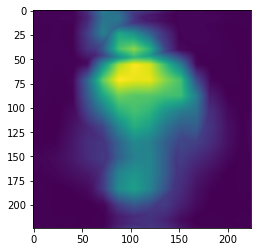

In [82]:
heatmap = scoreCAM.get_class_heatmap(457)
plt.imshow(heatmap)

In [28]:
from keras_applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array
import xml.etree.ElementTree as ET


def read_content(xml_file: str):

    tree = ET.parse(xml_file)
    root = tree.getroot()

    list_with_all_boxes = []

    for boxes in root.iter('object'):

        filename = root.find('filename').text

        ymin, xmin, ymax, xmax = None, None, None, None

        ymin = int(boxes.find("bndbox/ymin").text) #bottom
        xmin = int(boxes.find("bndbox/xmin").text) #left
        ymax = int(boxes.find("bndbox/ymax").text) #top
        xmax = int(boxes.find("bndbox/xmax").text) #right

        list_with_single_boxes = [xmin, ymin, xmax, ymax] #[left,bottom,right,top]
        list_with_all_boxes.append(list_with_single_boxes)

    return filename, list_with_all_boxes
#H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_10388.JPEG
#
def decile (name,class_id):
    #d = image.flatten()
    # model_input - is an input layer
    name_dir = name.split('_')[0]
    
    path = 'H:/imagenet_object_localization_patched2019/ILSVRC/Annotations/CLS-LOC/train/'+name_dir
    n, boxes = read_content(path+'/'+name+'.xml')
    #for filename in os.listdir(path):
        
    source_img = load_img(f'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'+name_dir+'/'+n+'.JPEG', target_size=input_shape)
    
    img = img_to_array(source_img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img, backend=keras.backend)
    im_name = scoreCAM.prepare_cam(img)
    heatmap = scoreCAM.get_class_heatmap(class_id)
        #for basename in img_basenames:
            #f_name, f_ext = os.path.splitext(basename)
            #f_name = f_name.split('.')[0]
        #if not boxes.empty:
            
            #sorted_df = df2.sort_values(by='filename', ascending=True)
            # = sorted_df.loc[sorted_df['filename'] == name].values.tolist()
    
    xmin = boxes[0][0]
    ymin = boxes[0][1]
    xmax=boxes[0][2]
    ymax =boxes[0][3]
            #n = B[0][1]
                
            #im = cv2.imread(f'H:/Juston_Charlotte/ScoreCAM_resultats/heatmaps/n02098105'+f_name+'.png')
    im1 = heatmap[ymin:ymax, xmin:xmax]
        #cv2.imwrite(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG', im1)
        #ima = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG')
    perc = np.percentile(im1, 90)
        
    return perc

In [29]:
#class id n02098105 : 202
decile('n02883205_24815',457)
#H:\imagenet_object_localization_patched2019\ILSVRC\Data\CLS-LOC\train

0.002191995386965573

In [30]:
decile('n02883205_10388',457)

0.001697566104121506

In [152]:
#bowtie
decile('n02883205_10388',457)

0.001697566104121506

In [31]:
#sunglasses
decile('n02883205_10388',837)

0.0053276546299457555

In [ ]:
from keras_applications.vgg16 import preprocess_input
from keras_preprocessing.image import load_img, img_to_array

source_img = load_img('H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n02883205/n02883205_46341.JPEG', target_size=input_shape)
img = img_to_array(source_img)
img = np.expand_dims(img, axis=0)
img = preprocess_input(img, backend=keras.backend)

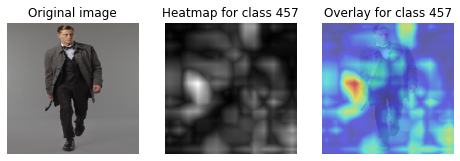

In [133]:
draw_original_and_heatmap_bw(457)

In [ ]:
heatmap = scoreCAM.get_class_heatmap(457)
plt.imshow(heatmap)

In [55]:
#model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#model = Model(inputs=vgg.input, outputs=bboxHead)
import keras
from keras.applications import VGG16
import numpy as np
model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
#model = VGG16(weights='imagenet')
input_shape = (224, 224)
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=[decile])

In [56]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [185]:
def read_and_preprocess_img(path, size=(224,224)):
    img = load_img(path, target_size=size)
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [ ]:
import os
import cv2
from PIL import Image
X = []
y = []
input_shape = (224,224)

path = 'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/n01440764/n01440764 - Raccourci.lnk'
download_dir = Path('H:/imagenet_object_localization_patched2019/ILSVRC/Data')
train_data_dir = 'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'
class_subset = sorted(os.listdir(download_dir/'CLS-LOC/train'))[:10] #

base_dir = 'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'
for f in sorted(os.listdir(base_dir)):
    if os.path.isdir(base_dir+f):
        
        #print(f"{f} is a target class")
        for i in sorted(os.listdir(base_dir+f)):
            #print(f"{i} is an input image path")
            #source_img = load_img(base_dir+f+'/'+i)
            #img = cv2.imread(base_dir+f+'/'+i
            #img_path = 'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'+f+'/'+i
            #orig_img = np.array(load_img(img_path),dtype=np.uint8)
            #img_array = read_and_preprocess_img(img_path, size=(224,224))
            if ((base_dir+f+'/'+i) == path):
                
                # skip directories
                continue

            im = Image.open(base_dir+f+'/'+i)
            out = im.resize(input_shape)
            #img = img_to_array(source_img)
            X.append(out)
            y.append(f)
#print(X)
#print(y)

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X,y, test_size=0.2, shuffle=True)

In [149]:
'''
import json
import glob
 
label_map = {}
 
dirs = glob.glob(base_dir + "*")
for i, dir in enumerate(dirs):
    label_map[dir.split("/")[-1]] = i

    
with open("label_map.json", "w") as file:
    file.write(json.dumps(label_map))
'''

In [28]:
import os
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
                                     validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preproc

In [29]:
download_dir = Path('H:/imagenet_object_localization_patched2019/ILSVRC/Data')
train_data_dir = 'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'
class_subset = sorted(os.listdir(download_dir/'CLS-LOC/train'))[:10] #

In [35]:
class_subset

['n01440764',
 'n01443537',
 'n01484850',
 'n01491361',
 'n01494475',
 'n01496331',
 'n01498041',
 'n01514668',
 'n01514859',
 'n01518878']

In [30]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               classes=class_subset,
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

Found 11050 images belonging to 10 classes.
Found 1950 images belonging to 10 classes.


In [31]:
nput_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=10

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

In [38]:
print(traingen)

In [33]:
%%time 

vgg_history = model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            
                            verbose=1)

Epoch 1/50


AttributeError: in user code:

    D:\Users\aalah_le\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-23-6aa44269e5af>:4 decile_two  *
        name_dir = name.split('_')[0]

    AttributeError: 'Tensor' object has no attribute 'split'


In [175]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=[decile])

In [143]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [25]:
x_train.shape

NameError: name 'x_train' is not defined

In [176]:
nb_epoch = 10
batch_size = 16

history = model.fit(x_train,y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(x_test,y_test))

Epoch 1/10


AttributeError: in user code:

    D:\Users\aalah_le\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\keras\engine\training.py:805 train_function  *
        return step_function(self, iterator)
    <ipython-input-28-95f1cce17c88>:33 decile  *
        name_dir = name.split('_')[0]

    AttributeError: 'Tensor' object has no attribute 'split'


In [ ]:
# initialize the input image shape (224x224 pixels) along with
# the pre-processing function (this might need to be changed
# based on which model we use to classify our image)
inputShape = (224, 224)
preprocess = imagenet_utils.preprocess_input

In [23]:
import listdir
from os.path import isfile, join
files_in_dir = [ f for f in listdir('H:/imagenet_object_localization_patched2019/ILSVRC/Annotations/CLS-LOC/train/') if isfile(join('H:/imagenet_object_localization_patched2019/ILSVRC/Annotations/CLS-LOC/train/',f)) ]
def decile_two (name,class_id):
    #d = image.flatten()
    # model_input - is an input layer
    for file in files_in_dir:
    with open(file, 'w') as f:
        
    #name_dir = name.split('_')[0]
    
        path = 'H:/imagenet_object_localization_patched2019/ILSVRC/Annotations/CLS-LOC/train/'+name_dir
        n, boxes = read_content(f)
    #for filename in os.listdir(path):
        
        source_img = load_img(f'H:/imagenet_object_localization_patched2019/ILSVRC/Data/CLS-LOC/train/'+name_dir+'/'+n+'.JPEG', target_size=input_shape)
    
    img = img_to_array(source_img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img, backend=keras.backend)
    im_name = scoreCAM.prepare_cam(img)
    heatmap = scoreCAM.get_class_heatmap(class_id)
        #for basename in img_basenames:
            #f_name, f_ext = os.path.splitext(basename)
            #f_name = f_name.split('.')[0]
        #if not boxes.empty:
            
            #sorted_df = df2.sort_values(by='filename', ascending=True)
            # = sorted_df.loc[sorted_df['filename'] == name].values.tolist()
    
    xmin = boxes[0][0]
    ymin = boxes[0][1]
    xmax=boxes[0][2]
    ymax =boxes[0][3]
            #n = B[0][1]
                
            #im = cv2.imread(f'H:/Juston_Charlotte/ScoreCAM_resultats/heatmaps/n02098105'+f_name+'.png')
    im1 = heatmap[ymin:ymax, xmin:xmax]
        #cv2.imwrite(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG', im1)
        #ima = cv2.imread(f'R:/Bureau/n03297495_ScoreCAM/annot/'+n+'_crop.JPEG')
    perc = np.percentile(im1, 90)
        
    return 1 - perc

In [26]:
nb_epoch = 10
batch_size = 16
model.compile(optimizer='Adam', loss=decile_two, metrics=["accuracy"])
history = model.fit(traingen,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=validgen)

NameError: name 'traingen' is not defined